<a href="https://colab.research.google.com/github/artem-bezrukov/spring_2022/blob/main/ml/lab_3/%D0%9B%D0%90%D0%91_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЛАБОРАТОРНАЯ РАБОТА №3

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, classification_report, average_precision_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
%config InlineBackend.figure_format = 'svg'
sns.set_style('whitegrid')
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df=pd.read_csv("/content/drive/MyDrive/titanic.csv",sep =';',decimal=',');

Mounted at /content/drive


1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных.

In [ ]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [ ]:
list_to_drop = ['body', 'boat','cabin', 'ticket','name','home.dest']
df.drop(list_to_drop, axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


В файле описана информация о пассажирах судна: класс, вижил/не выжил, имя, пол, возраст,братья/сёстры, родители/дети, номер билета, тариф, каюта, посадка, шлюпка, место назначения.

2.Удалите дубликаты строк в наборе данных.

In [ ]:
df = df.drop_duplicates()
print('dataset size', df.shape)
df.count()

dataset size (1114, 8)


pclass      1114
survived    1114
sex         1114
age          974
sibsp       1114
parch       1114
fare        1113
embarked    1112
dtype: int64

3.Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая).

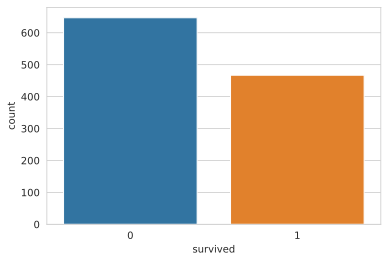

In [ ]:
sns.countplot(data=df, x='survived')
plt.show()




Разброс достаточно большой, поэтому используем PR-кривую.

4. Выполните масштабирование количественных признаков

Разделяем признаки на числовые и категориальные


In [ ]:

numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)


numerical:  ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']
categorial:  ['sex', 'embarked']


Далее нормализуем числовые признаки

In [ ]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,0.0,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,0.0,1.0,male,0.009395,0.125,0.222222,0.295806,S
2,0.0,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,0.0,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,0.0,0.0,female,0.311064,0.125,0.222222,0.295806,S
...,...,...,...,...,...,...,...,...
1303,1.0,0.0,male,NaN,0.000,0.000000,0.028221,C
1304,1.0,0.0,female,0.179540,0.125,0.000000,0.028213,C
1306,1.0,0.0,male,0.329854,0.000,0.000000,0.014102,C
1307,1.0,0.0,male,0.336117,0.000,0.000000,0.014102,C


5) Выполните замену категориальных признаков


In [ ]:
for i in categorial_columns:
    print(i,': ', df[i].unique())

sex :  ['female' 'male']
embarked :  ['S' 'C' nan 'Q']


In [ ]:
df.at[df['sex'] == 'male', 'sex'] = 1
df.at[df['sex'] == 'female', 'sex'] = 0
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,0.0,1.0,0,0.361169,0.000,0.000000,0.412503,S
1,0.0,1.0,1,0.009395,0.125,0.222222,0.295806,S
2,0.0,0.0,0,0.022964,0.125,0.222222,0.295806,S
3,0.0,0.0,1,0.373695,0.125,0.222222,0.295806,S
4,0.0,0.0,0,0.311064,0.125,0.222222,0.295806,S


In [ ]:
binary = ['sex']
nonbinary = ['embarked']
print('Бинарные: ', binary)
print('Небинарные: ', nonbinary)

Бинарные:  ['sex']
Небинарные:  ['embarked']


In [ ]:
df_nonbinary = pd.get_dummies(df[nonbinary])
df.drop(nonbinary, axis=1, inplace=True)
df = pd.concat([df, df_nonbinary], axis=1)

df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0.0,1.0,0,0.361169,0.000,0.000000,0.412503,0,0,1
1,0.0,1.0,1,0.009395,0.125,0.222222,0.295806,0,0,1
2,0.0,0.0,0,0.022964,0.125,0.222222,0.295806,0,0,1
3,0.0,0.0,1,0.373695,0.125,0.222222,0.295806,0,0,1
4,0.0,0.0,0,0.311064,0.125,0.222222,0.295806,0,0,1


6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

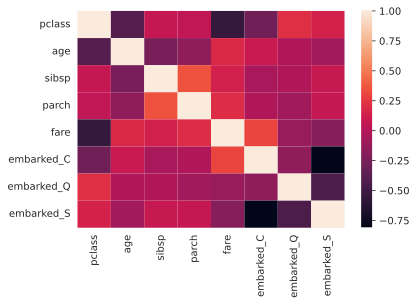

In [ ]:
df_corr = df.drop('survived', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

7. Заполните пропущенные значения в данных

In [ ]:
df = df.fillna(df.median(axis=0), axis=0)
df.count()

pclass        1114
survived      1114
sex           1114
age           1114
sibsp         1114
parch         1114
fare          1114
embarked_C    1114
embarked_Q    1114
embarked_S    1114
dtype: int64

8. Решите поставленную задачу классификации в соответствии с заданием

In [ ]:

x, y = df.drop('survived', axis = 1), df['survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123)

перемешиваем данные через train_test_spilit

In [ ]:

rnc = RadiusNeighborsClassifier(outlier_label = 1)
params = {'radius': np.arange(0, 5, 0.25)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(x_train, y_train)



best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train :', best_score, '\n radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label = 1, radius = best_radius)
rnc.fit(x_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(x_test))
print('test: ', best_score)

best train : 0.775409429280397 
 radius: 0.75
test score:  0.7492537313432835


Нахожу лучшие параметры для обучения черег GSCV и оптимальный радиус

In [ ]:
perc = Perceptron()
perc.get_params()
{'alpha': 0.0001,
 'class_weight': None,
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': None,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

{'alpha': 0.0001,
 'class_weight': None,
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': None,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
paramsearch = GridSearchCV(estimator = perc, param_grid = dict(alpha = np.linspace(0,2,20)[1:], max_iter = [int(50)]), n_jobs = int(10))
paramsearch.fit(x_train, y_train)

GridSearchCV(estimator=Perceptron(), n_jobs=10,
             param_grid={'alpha': array([0.10526316, 0.21052632, 0.31578947, 0.42105263, 0.52631579,
       0.63157895, 0.73684211, 0.84210526, 0.94736842, 1.05263158,
       1.15789474, 1.26315789, 1.36842105, 1.47368421, 1.57894737,
       1.68421053, 1.78947368, 1.89473684, 2.        ]),
                         'max_iter': [50]})

In [ ]:
best_score = paramsearch.best_score_
selected_alpha = paramsearch.best_estimator_.alpha
print('best train score: ', best_score, 'at alpha', selected_alpha)
best_n_iter = paramsearch.best_estimator_.max_iter
best_n_jobs = paramsearch.best_estimator_.n_jobs

best train score:  0.7227460711331679 at alpha 0.10526315789473684


In [ ]:
dtc = Perceptron(alpha = selected_alpha, max_iter = best_n_iter, n_jobs = best_n_jobs)
dtc.fit(x_train, y_train)
test_score = np.mean(y_test == dtc.predict(x_test))
print('test score: ', test_score)

test score:  0.7373134328358208


In [ ]:
plt.figure(figsize = (10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop = True)):
    y_test_invers.append(1 - y)
    
probas_rnc0 = rnc.fit(x_train, y_train).predict_proba (x_test)
probas_rnc1 = rnc.fit(x_train, y_train).predict_proba (x_test)

clf_isotonic = CalibratedClassifierCV(perc, cv = 10, method = 'isotonic')
clf_isotonic.fit(x_train, y_train)
probas_perc0 = clf_isotonic.predict_proba(x_test)
clf_isotonic.fit(x_train, y_train)
probas_perc1 = clf_isotonic.predict_proba(x_test)


<Figure size 720x576 with 0 Axes>

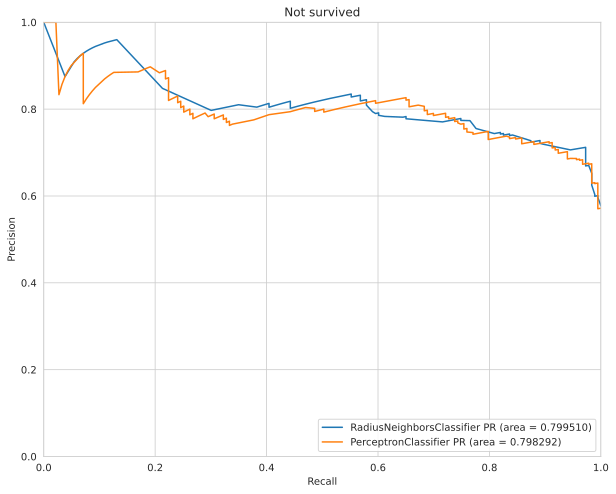

In [ ]:
plt.figure(figsize = (10,8))

precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_rnc1[:,0])
aps_rnc1 = average_precision_score(y_test_invers,probas_rnc1[:,0])
plt.plot(recall, precision, label = '%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_rnc1))


precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_perc1[:,0])
aps_perc1 = average_precision_score(y_test_invers, probas_perc1[:,0])
plt.plot(recall, precision, label = '%s PR (area = %f)' % ('PerceptronClassifier',  aps_perc1))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 4, fontsize = 'medium')
plt.title('Not survived')
plt.show()

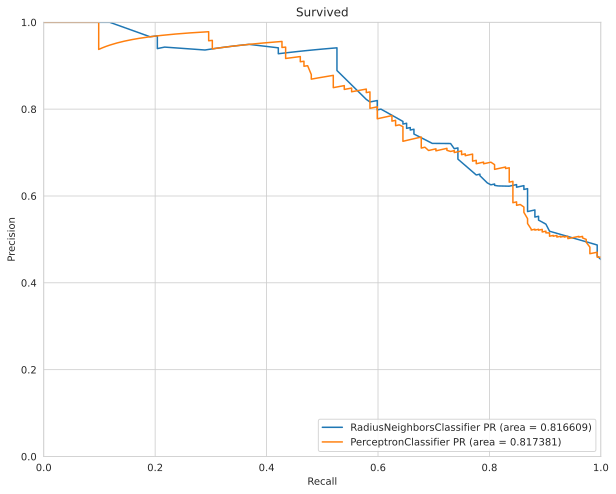

In [ ]:
plt.figure(figsize = (10,8))


precision, recall, thresholds = precision_recall_curve(y_test, probas_rnc0[:,1])
aps_rnc0 = average_precision_score(y_test,probas_rnc0[:,1])
plt.plot(recall, precision, label = '%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_rnc0))


precision, recall, thresholds = precision_recall_curve(y_test, probas_perc1[:,1])
aps_perc1 = average_precision_score(y_test,probas_perc1[:,1])
plt.plot(recall, precision, label = '%s PR (area = %f)' % ('PerceptronClassifier',  aps_perc1))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 4, fontsize = 'medium')
plt.title('Survived')
plt.show()

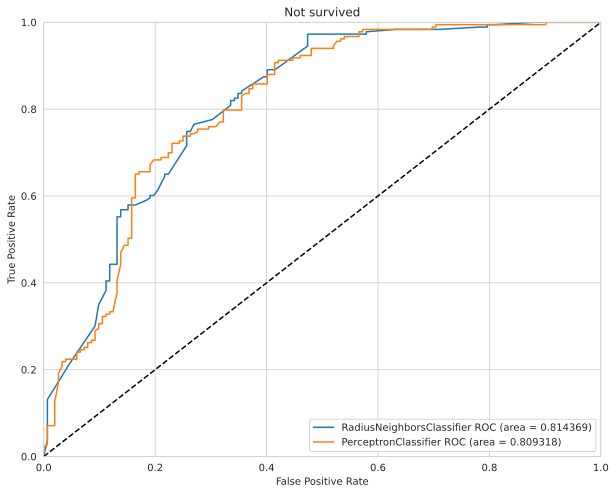

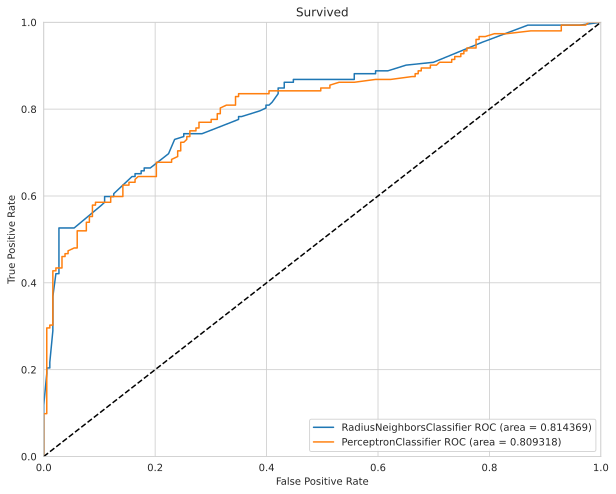

In [ ]:



plt.figure(figsize = (10,8))


tpr, fpr, thresholds = roc_curve(y_test, probas_rnc0[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = '%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 


tpr, fpr, thresholds = roc_curve(y_test, probas_perc0[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = '%s ROC (area = %f)' % ('PerceptronClassifier', roc_auc))   


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4, fontsize = 'medium')
plt.title('Not survived')
plt.show()

plt.figure(figsize = (10,8))


fpr, tpr, thresholds = roc_curve(y_test, probas_rnc1[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = '%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc))


fpr, tpr, thresholds = roc_curve(y_test, probas_perc1[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = '%s ROC (area = %f)' % ('PerceptronClassifier', roc_auc))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4, fontsize = 'medium')
plt.title('Survived')
plt.show()